# Setup Paths

In [1]:
import os

In [2]:

CUSTOM_MODEL_NAME = 'col_faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8'
PRETRAINED_MODEL_NAME = 'faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'APIMODEL_PATH': os.path.join('od_tf_model'),
    'ANNOTATION_PATH': os.path.join('annotations'),
    'IMAGE_PATH': os.path.join('images'),
    'MODEL_PATH': os.path.join('my_models'),
    'PRETRAINED_MODEL_PATH': os.path.join('pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('my_models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('my_models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('my_models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('my_models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join(paths['MODEL_PATH'], CUSTOM_MODEL_NAME, 'pipeline.config'),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:

for path in paths.values():
  os.makedirs(path,exist_ok=True)



# get dataset

In [14]:
! git clone https://github.com/Ala-Alsanea/sketch_web_ui_dataset.git {paths['IMAGE_PATH']}

Cloning into 'images'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 103 (delta 55), reused 71 (delta 26), pack-reused 0
Receiving objects: 100% (103/103), 23.50 MiB | 39.98 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [ ]:
!cd {paths['IMAGE_PATH']} && python setup.py

In [ ]:
!python {paths['IMAGE_PATH']}/create_new_dataset_and_preprocess.py -p {paths['IMAGE_PATH']}

In [17]:
import shutil


shutil.copy2(os.path.join(paths['IMAGE_PATH'],'label_map.pbtxt'),paths['ANNOTATION_PATH'])
shutil.copy2(os.path.join(paths['IMAGE_PATH'],'train.record'),paths['ANNOTATION_PATH'])
shutil.copy2(os.path.join(paths['IMAGE_PATH'],'test.record'),paths['ANNOTATION_PATH'])
'done'

'done'

In [6]:
if os.name =='posix':
    !wget -c {PRETRAINED_MODEL_URL} 
    !tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'} -C {paths['PRETRAINED_MODEL_PATH']}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2023-05-23 06:39:51--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.219.128, 2607:f8b0:4001:c13::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.219.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444343592 (424M) [application/x-tar]
Saving to: ‘faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz’

faster_rcnn_incepti 100%[===================>] 423.76M   215MB/s    in 2.0s    

2023-05-23 06:39:53 (215 MB/s) - ‘faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz’ saved [444343592/444343592]

faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8/
faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8/checkpoint/
faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8/checkpoint/c

#  Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [7]:
# https://www.tensorflow.org/install/source_windows

In [8]:
if os.name=='nt':
    !pip install wget
    import wget

In [9]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

# get Label Map

In [10]:
from object_detection.utils import dataset_util, label_map_util

labels_map = label_map_util.load_labelmap(files['LABELMAP'])
labels = label_map_util.get_label_map_dict(labels_map)


labels 


{'Button': 1,
 'CheckBox': 2,
 'Heading': 3,
 'Image': 4,
 'Label': 5,
 'Link': 6,
 'Paragraph': 7,
 'RadioButton': 8,
 'Select': 9,
 'TextBox': 10}

In [11]:
import object_detection

# Copy Model Config to Training Folder

In [12]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

#  Update Config For Transfer Learning

In [44]:
BATCH_SIZE = 2
STEPS = 10000

In [45]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [46]:
files['PIPELINE_CONFIG']

'my_models/col_faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8/pipeline.config'

In [47]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [48]:
config

{'model': faster_rcnn {
   num_classes: 10
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "faster_rcnn_inception_resnet_v2_keras"
     batch_norm_trainable: true
   }
   first_stage_anchor_generator {
     grid_anchor_generator {
       height_stride: 16
       width_stride: 16
       scales: 0.25
       scales: 0.5
       scales: 1.0
       scales: 2.0
       aspect_ratios: 0.5
       aspect_ratios: 1.0
       aspect_ratios: 2.0
     }
   }
   first_stage_box_predictor_conv_hyperparams {
     op: CONV
     regularizer {
       l2_regularizer {
         weight: 0.0
       }
     }
     initializer {
       truncated_normal_initializer {
         stddev: 0.009999999776482582
       }
     }
   }
   first_stage_nms_score_threshold: 0.0
   first_stage_nms_iou_threshold: 0.699999988079071
   first_stage_max_proposals: 300
   first_stage_localization_loss_weight: 2.0
   first_stage_objectness_loss_weight: 1.0


In [49]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [50]:
# pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.model.faster_rcnn.num_classes = len(labels)
pipeline_config.train_config.batch_size = BATCH_SIZE
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [51]:
pipeline_config

model {
  faster_rcnn {
    num_classes: 10
    image_resizer {
      fixed_shape_resizer {
        height: 640
        width: 640
      }
    }
    feature_extractor {
      type: "faster_rcnn_inception_resnet_v2_keras"
      batch_norm_trainable: true
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        height_stride: 16
        width_stride: 16
        scales: 0.25
        scales: 0.5
        scales: 1.0
        scales: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 1.0
        aspect_ratios: 2.0
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.009999999776482582
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.699999988079071
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
  

In [52]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# Train the model

In [53]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [54]:
paths['CHECKPOINT_PATH']

'my_models/col_faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8'

In [55]:
command = "python3 {} --model_dir={} --pipeline_config_path={} --num_train_steps={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'],STEPS)

In [56]:
print(command)

python3 od_tf_model/research/object_detection/model_main_tf2.py --model_dir=my_models/col_faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8 --pipeline_config_path=my_models/col_faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8/pipeline.config --num_train_steps=10000


In [ ]:
!{command}

# 7. Evaluate the Model

In [46]:
command = "python3 {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [47]:
print(command)

python3 od_tf_model/research/object_detection/model_main_tf2.py --model_dir=my_models/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8 --pipeline_config_path=my_models/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config --checkpoint_dir=my_models/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8


In [ ]:
!{command}

# 8. Load Train Model From Checkpoint

In [ ]:
!pip3 uninstall numpy -y
!pip3 install numpy

In [ ]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [7]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-5')).expect_partial()
# print(ckpt)


# @tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [8]:
import cv2 
import numpy as np
import urllib
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
category_index

{1: {'id': 1, 'name': 'Button'},
 2: {'id': 2, 'name': 'CheckBox'},
 3: {'id': 3, 'name': 'Heading'},
 4: {'id': 4, 'name': 'Image'},
 5: {'id': 5, 'name': 'Label'},
 6: {'id': 6, 'name': 'Link'},
 7: {'id': 7, 'name': 'Paragraph'},
 8: {'id': 8, 'name': 'RadioButton'},
 9: {'id': 9, 'name': 'Select'},
 10: {'id': 10, 'name': 'TextBox'}}

In [20]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test','images','e6b36cb6-83a0-4865-8b33-52822722ef50.png')

URL = 'https://whatpixel.com/images/2015/12/04-website-homepage-wireframe.jpg'
req = urllib.request.urlopen(URL)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)


720
(720, 720, 3)


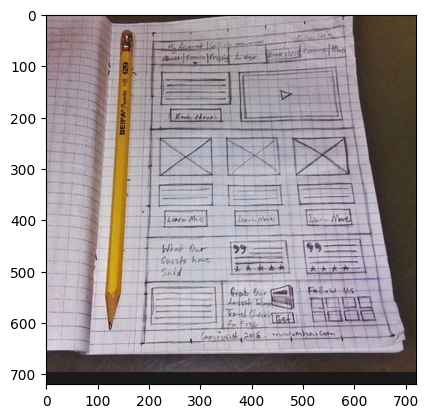

In [30]:
#from url
# 'Load it as it is'
img = cv2.imdecode(arr, -1,) 
img = cv2.cvtColor(img,1)
# print(img)


#locale
# img = cv2.imread(IMAGE_PATH)


# plt.imshow(img)
# plt.show()

image_np = np.array(img)
# image_np = np.expand_dims(image_np, 1)
print(len(image_np))

print(image_np.shape)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

detections = detect_fn(input_tensor)


num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5,
            agnostic_mode=False)

cv2.imwrite('1.jpg',image_np_with_detections)
# cv2.imshow('frame', cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))

# cap.release()
# cv2.destroyAllWindows()

# print(detections.keys())
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# 10. Real Time Detections from your Webcam

In [ ]:
# !pip uninstall opencv-python-headless -y

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

#  Freezing the Graph

In [31]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [32]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [33]:
print(command)

python od_tf_model/research/object_detection/exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=my_models/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config --trained_checkpoint_dir=my_models/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8 --output_directory=my_models/my_ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/export


In [ ]:
!{command}

#  Zip and Export Models 

In [41]:
paths['CHECKPOINT_PATH']
CUSTOM_MODEL_NAME
STEPS

4000

In [43]:
!tar -czf {CUSTOM_MODEL_NAME}_{STEPS}step.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#  Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

#  Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
!{command}